The following analysis was executed using commit `b6e4fe952` of the [exosyspop](github.com/timothydmorton/exosyspop) module.

In [1]:
# Set up plot stuff the DFM way:
%matplotlib inline
import matplotlib.pyplot as plt

%run ../peerless/plot_setup.py

In [76]:
!../scripts/peerless-targets

Saving 39036 targets to /Users/tdm/peerless/catalogs/targets.csv


In [79]:
from peerless.catalogs import TargetCatalog, EBCatalog
targets = TargetCatalog().df

In [80]:
targets[['kepid','mass','feh']].count()

kepid    39036
mass     38410
feh      39036
dtype: int64

In [81]:
# funny, there seem to be some missing masses.  Let's artificially add those in, with M=R
bad = targets.mass.isnull()
targets.loc[bad, 'mass'] = targets.loc[bad, 'radius']

In [82]:
# Calculate galactic latitude of target stars
from astropy.coordinates import SkyCoord
c = SkyCoord(targets.ra, targets.dec, unit='deg')
targets['b'] = c.galactic.b.deg

In [83]:
from exosyspop.populations import KeplerPowerLawBinaryPopulation
from exosyspop.populations import TRILEGAL_BGPowerLawBinaryPopulation

ebpop = KeplerPowerLawBinaryPopulation(targets, ecc_empirical=True)
bgstars = pd.read_hdf('bgstars.h5', 'df')
bgpop = TRILEGAL_BGPowerLawBinaryPopulation(targets, bgstars, ecc_empirical=True, use_ic=True)

136.401367662
153


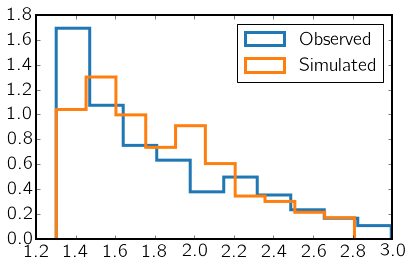

In [108]:
from __future__ import division

min_period = 20
max_period = 25*365.25
fB = 0.15
beta = -1.1
ebpop.set_params(beta=beta, period_min=min_period, period_max=max_period, fB=fB)

q = 'period > {} and period < 1000 and '.format(min_period) +\
    '((n_pri > 0 and n_sec > 0) or ' +\
     '(n_pri > 2 or n_sec > 2)) and (T14_pri < 2.5 or T14_sec < 2.5)'

kep_ebs = EBCatalog().df.query('{} < period < 1000'.format(min_period))
n_exp = len(kep_ebs) * (len(targets)/len(KICatalog().df))
print(n_exp)
plt.hist(np.log10(kep_ebs.period), 
         histtype='step', lw=3, normed=True, label='Observed');
new_obs = ebpop.observe(new_orbits=True).query(q)
plt.hist(np.log10(new_obs.period), label='Simulated',
        histtype='step', lw=3, normed=True);
plt.legend()
print(len(new_obs))

In [109]:
ebpop.params

{'beta': -1.1,
 'beta_a': 0.8,
 'beta_b': 2.0,
 'fB': 0.15,
 'gamma': 0.3,
 'period_max': 9131.25,
 'period_min': 20,
 'qmin': 0.1}

In [110]:
# Set params to match above
pars = dict(period_min=min_period, period_max=max_period, beta=beta, fB=fB)
ebpop.set_params(**pars)
bgpop.set_params(**pars)
ebpop._generate_binaries()
bgpop._generate_binaries()

Let's do a bunch of these observation simulations and see what it looks like:

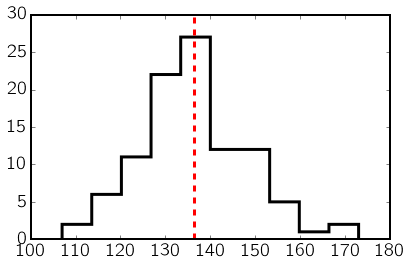

In [111]:
n_obs = [len(ebpop.observe(new_orbits=True).query(q)) for i in range(100)]

plt.hist(n_obs, histtype='step', lw=3, bins=10, color='k');
plt.axvline(n_exp, color='r', ls='--', lw=3);

OK, now that we can roughly match the Kepler EB catalog from 20 to 1000d with these EB population parameters, we want to know what's the typical number of single/double eclipse signals.

In [112]:
ebpop._train_trap(N=1000);
bgpop._train_trap(N=1000);

EB: Depth trained: R2=0.998841943165
EB: Duration trained: R2=0.997435262402
EB: Slope trained: R2=0.980777458662
BGEB: Depth trained: R2=0.994487728442
BGEB: Duration trained: R2=0.998174985036
BGEB: Slope trained: R2=0.985989102635


In [113]:
n_sim = 100
dfm_q = 'n_pri < 3 and n_sec < 3 and ((n_pri==0 and snr_sec > 15) or (n_sec==0 and snr_pri > 15))'
dfm_q += ' and ((T14_pri < 2.5 and n_pri > 0) or (T14_sec < 2.5 and n_sec > 0))'
nobs_eb = [len(ebpop.observe(new_orbits=True, regr_trap=True).query(dfm_q)) for i in range(n_sim)]
nobs_bg = [len(bgpop.observe(new_orbits=True, regr_trap=True).query(dfm_q)) for i in range(n_sim)]

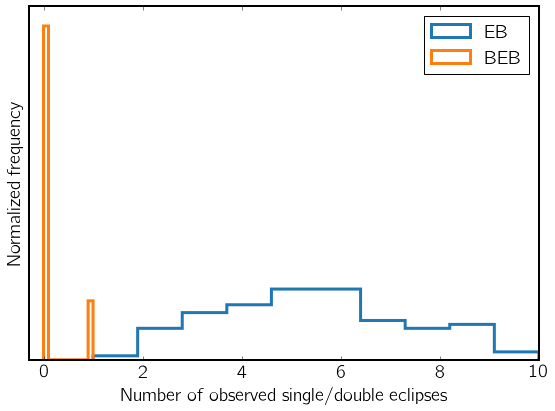

In [114]:
plt.figure(figsize=(8,6))
plt.hist(nobs_eb, histtype='step', lw=3, label='EB')#, bins=np.arange(16));
plt.hist(nobs_bg, histtype='step', lw=3, label='BEB')#, bins=np.arange(16));
plt.legend();
plt.xlim(xmin=-0.3)
plt.yticks([])
plt.ylabel('Normalized frequency')
plt.xlabel('Number of observed single/double eclipses');
plt.savefig('N_EBs.pdf', bbox_inches='tight')

OK, now let's determine the typical shapes.  Let's do this with a big sample of simulated observations.

In [115]:
np.mean(nobs_eb), np.mean(nobs_bg)

(5.4199999999999999, 0.14999999999999999)

In [116]:
eb_obs = ebpop.get_N_observed(query=dfm_q, N=2000, new_orbits=True)
bg_obs = bgpop.get_N_observed(query=dfm_q, N=200, use_ic=True, new_orbits=True) #takes longer; use fewer

OK, now let's load up the candidates.

In [245]:
from keputils import kicutils as kicu

In [251]:
candidates_all = pd.read_csv('../results/candidates.csv')
targets.index = targets['kepid']
rstar = []
for k in candidates.kicid:
    if k in targets.index:
        rstar.append(targets.ix[k, 'radius'])
    else:
        print('{} not in target list'.format(k))
        rstar.append(kicu.DATA.ix[k, 'radius'])
rstar = np.array(rstar) 
candidates_all['rp'] = candidates.transit_ror * rstar * RSUN/RJUP
candidates = candidates_all.query('accept_bic and accept_time and num_peaks <= 2 and rp < 1')

print(len(candidates))
candidates[['depth','transit_duration','s2n','rp']]

18


,depth,transit_duration,s2n,rp
6,0.000346,0.716957,28.485282,0.184335
33,0.004086,0.496911,78.893061,0.629314
35,0.000881,0.405306,34.391561,0.280589
47,0.003687,0.515208,88.882287,0.703130
69,0.004205,1.509684,77.287999,0.683020
88,0.007903,0.780640,158.604425,0.853172
123,0.004480,0.888443,75.278868,0.457690
126,0.015872,0.672062,392.762344,0.844417
127,0.015061,0.670561,390.821950,0.829935
161,0.002230,0.681862,39.953932,0.668581


In [242]:
for k in candidates_all.kicid:
    try:
        targets.ix[k, 'radius']
    except KeyError:
        print(k)

10271691
10613792
10613792
11038446
12204153
6751029
7987086
7987086
7987086
7971363
8540644
8584610
9159119
9730194
9701988
9701988


In [232]:
targets.head()

,kepid,tm_designation,teff,teff_err1,teff_err2,logg,logg_err1,logg_err2,feh,feh_err1,...,rrmscdpp07p5,rrmscdpp09p0,rrmscdpp10p5,rrmscdpp12p0,rrmscdpp12p5,rrmscdpp15p0,av,av_err1,av_err2,b
kepid,,,,,,,,,,,,,,,,,,,,,
10022908,10022908,2MASS J19444255+4659564,4848,151.0,-126.0,4.598,0.016,-0.072,0.34,0.12,...,124.355,116.900,112.088,108.182,107.503,102.807,NaN,NaN,NaN,11.166494
10023002,10023002,2MASS J19444948+4657598,5823,142.0,-196.0,4.473,0.043,-0.292,0.36,0.08,...,25.008,23.527,22.575,21.715,21.496,20.204,NaN,NaN,NaN,11.133867
10023076,10023076,2MASS J19445637+4659198,5918,153.0,-157.0,4.546,0.028,-0.288,-0.26,0.28,...,48.607,44.790,41.917,39.582,38.903,35.278,NaN,NaN,NaN,11.127013
10026901,10026901,2MASS J19493252+4654151,5695,154.0,-162.0,4.545,0.027,-0.240,-0.02,0.23,...,111.503,103.698,97.152,91.653,90.019,83.076,NaN,NaN,NaN,10.396107
10026977,10026977,2MASS J19493720+4657282,5858,161.0,-185.0,4.495,0.038,-0.295,0.10,0.18,...,130.213,124.733,120.421,117.553,116.963,115.482,NaN,NaN,NaN,10.410278


In [254]:
candidates.s2n.min()

18.096212254112913

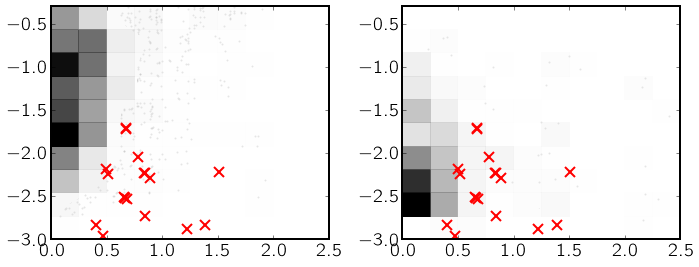

In [255]:
from corner import hist2d

fix, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

hist2d(eb_obs.observed.dur_pri.values, eb_obs.observed.logd_pri.values,
          plot_contours=False, ax=ax1, range=[(0,2.5), (-3, -0.3)], bins=10);
hist2d(bg_obs.observed.dur_pri.values, bg_obs.observed.logd_pri.values,
          plot_contours=False, ax=ax2, range=[(0,2.5), (-3, -0.3)], bins=10);

for ax in (ax1, ax2):
    ax.plot(candidates.transit_duration, np.log10(candidates.transit_depth), 'rx', ms=10)


In [256]:
from scipy.stats import gaussian_kde

eb_kde = gaussian_kde(np.array([eb_obs.observed.dur_pri, eb_obs.observed.logd_pri]))
bg_kde = gaussian_kde(np.array([bg_obs.observed.dur_pri, bg_obs.observed.logd_pri]))

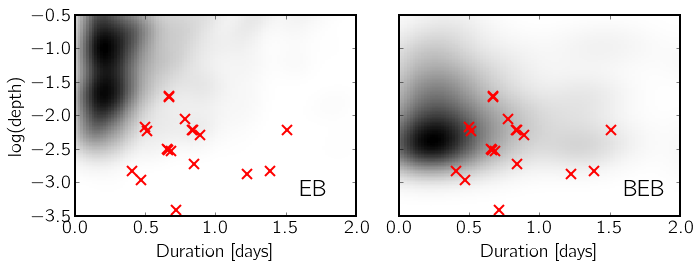

In [257]:
def plot_kde(kde, ax=None, dur_range=(0,2.), depth_range=(-3.5,-0.5), 
            cands=candidates, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1)
        
    dur_grid = np.arange(dur_range[0], dur_range[1], 0.02)
    depth_grid = np.arange(depth_range[0], depth_range[1], 0.02)
    xx, yy = np.meshgrid(dur_grid, depth_grid)
    f = kde(np.vstack([xx.ravel(),yy.ravel()])).reshape(xx.shape)
    ax.imshow(f, origin='lower', extent=[dur_range[0], dur_range[1],
                                         depth_range[0], depth_range[1]], 
               aspect='auto', cmap='binary', **kwargs)
    ax.set_xlabel('Duration [days]')
    ax.set_ylabel('log(depth)')
    
    if cands is not None:
        ax.plot(cands.transit_duration, np.log10(cands.transit_depth), 'rx', ms=10)
    
fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)
plot_kde(eb_kde, ax=axes[0])
plot_kde(bg_kde, ax=axes[1])
axes[1].set_ylabel('')
plt.subplots_adjust(wspace=0)
for ax,title in zip(axes, ['EB','BEB']):
    ax.annotate(title, xy=(0.8,0.1), xycoords='axes fraction', fontsize=22)

In [258]:
len(candidates)

18

In [259]:
# Here, defining population to match what was fit for in the paper
from exosyspop.populations import PlanetPopulation, REARTH, RSUN

import astropy.constants as const
RJUP = const.R_jup.cgs

class LongPeriodPlanetPopulation(PlanetPopulation):
    """
    Poisson Population in two bins: 0.1-0.4 RJup and 0.4-1.0 RJup
    
    From 2 to 25 years, with beta eccentricity distribution
    """
    min_period = 2*365.25
    max_period = 25*365.25
    
    param_names = ('Gam1', 'Gam2', 'beta_a', 'beta_b')
    default_params = {'Gam1':0.24, 'Gam2':0.18,
                      'beta_a':0.8, 'beta_b':2.0}
    
    def _sample_period(self, N):
        lo = np.log(self.min_period)
        hi = np.log(self.max_period)
        logp = np.random.random(N)*(hi - lo) + lo
        return np.exp(logp)
    
    def _sample_Np(self, N):
        Gam1, Gam2 = self._get_params(['Gam1', 'Gam2'])
        N_pl = Gam1 + Gam2 # Sum of both bins is total rate
        return np.random.poisson(N_pl, size=N)
    
    def _sample_Rp(self, N):
        Gam1, Gam2 = self._get_params(['Gam1', 'Gam2'])
        
        # Assign radii uniformly in each bin, with appropriate ratio given to each bin
        f1 = Gam1 / (Gam1 + Gam2)
        u = np.random.random(N)
        in_1 = u < f1
        in_2 = u >= f1
        N1 = in_1.sum()
        N2 = in_2.sum()
        
        Rp = np.ones(N)
        lo1, hi1 = np.log(0.1), np.log(0.4)
        lo2, hi2 = np.log(0.4), np.log(1)
        Rp[in_1] = np.exp(np.random.random(N1)*(hi1 - lo1) + lo1)
        Rp[in_2] = np.exp(np.random.random(N2)*(hi2 - lo2) + lo2)
        return Rp * RJUP/RSUN

In [260]:
plpop = LongPeriodPlanetPopulation(targets)

In [261]:
plpop._train_trap(N=1000);

Planet: Depth trained: R2=0.999631351961
Planet: Duration trained: R2=0.996814106923
Planet: Slope trained: R2=0.9825439937


In [262]:
plpop.params

{'Gam1': 0.24, 'Gam2': 0.18, 'beta_a': 0.8, 'beta_b': 2.0}

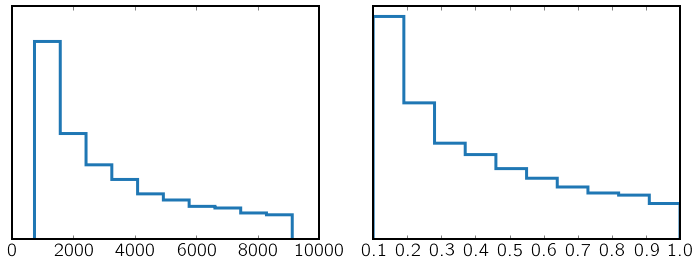

In [263]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.hist(plpop.period, histtype='step', lw=3);
ax1.set_yticks([])
ax2.hist(plpop.radius_B*RSUN/RJUP, histtype='step', lw=3);
ax2.set_yticks([]);

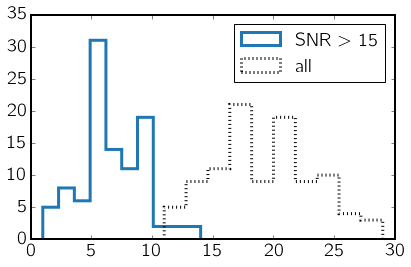

In [264]:
dfm_q_pl = 'n_pri < 3 and snr_pri > 15 and T14_pri < 2.5'
dfm_q_pl_nosnr = 'n_pri < 3 and T14_pri < 2.5 and snr_pri > 0'

nobs_pl = [len(plpop.observe(new_orbits=True, regr_trap=True).query(dfm_q_pl)) for i in range(100)]
nobs_pl2 = [len(plpop.observe(new_orbits=True, regr_trap=True).query(dfm_q_pl_nosnr)) for i in range(100)]

plt.hist(nobs_pl, histtype='step', lw=3, label='SNR $>$ 15');
plt.hist(nobs_pl2, histtype='step', lw=3, color='k', ls=':', label='all')
plt.legend(loc='upper right');

In [265]:
np.mean(nobs_pl)

6.5700000000000003

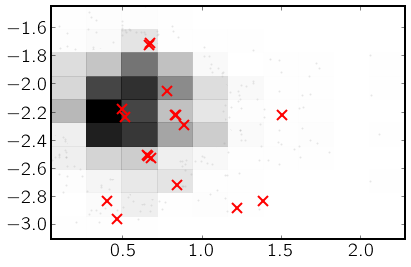

In [266]:
N = 1000
pl_obs = plpop.get_N_observed(query=dfm_q_pl, N=N)

hist2d(pl_obs.observed.dur_pri.values, pl_obs.observed.logd_pri.values,
          plot_contours=False, bins=10);

plt.plot(candidates.transit_duration, np.log10(candidates.transit_depth), 'rx', ms=10);

In [267]:
pl_obs.columns

Index([u'index', u'host', u'period', u'ecc', u'w', u'inc', u'a', u'aR',
       u'b_pri', u'b_sec', u'k', u'tra', u'occ', u'd_pri', u'd_sec',
       u'T14_pri', u'T14_sec', u'T23_pri', u'T23_sec', u'dataspan',
       u'dutycycle', u'flux_ratio', u'dilution', u'n_pri', u'n_sec',
       u'phase_sec', u'trap_dur_pri_regr', u'trap_depth_pri_regr',
       u'trap_slope_pri_regr', u'trap_dur_sec_regr', u'trap_depth_sec_regr',
       u'trap_slope_sec_regr', u'noise_pri', u'noise_sec', u'snr_pri',
       u'snr_sec', u'mean_depth_pri', u'mean_depth_sec'],
      dtype='object')

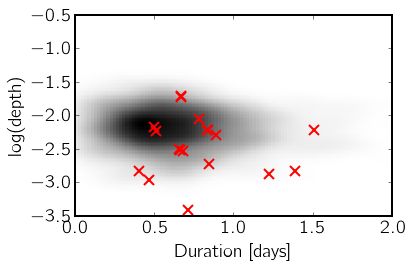

In [268]:
pl_kde = gaussian_kde(np.array([pl_obs.observed.dur_pri, pl_obs.observed.logd_pri]))
plot_kde(pl_kde)

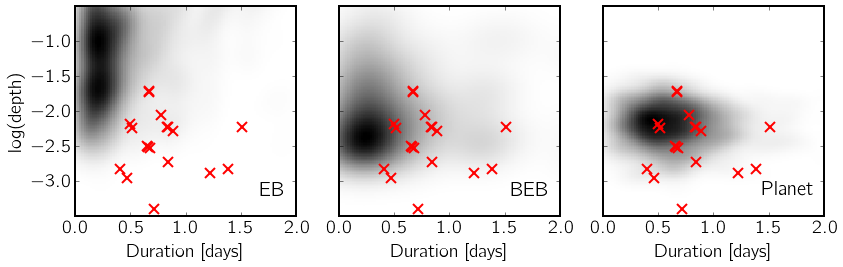

In [269]:
fig, axes = plt.subplots(1,3, figsize=(12,4), sharey=True)
plot_kde(eb_kde, ax=axes[0])
plot_kde(bg_kde, ax=axes[1])
plot_kde(pl_kde, ax=axes[2])
axes[1].set_ylabel('')
axes[2].set_ylabel('')
plt.subplots_adjust(wspace=0)
for ax,title in zip(axes, ['EB','BEB','Planet']):
    ax.set_yticks(np.arange(-3,-0.5,0.5))
    ax.annotate(title, xy=(0.95,0.1), xycoords='axes fraction', fontsize=20, ha='right')
    
plt.savefig('shape_kdes.pdf', bbox_inches='tight')

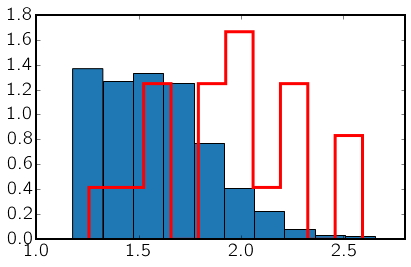

In [270]:
# Just curious...
plt.hist(np.log10(pl_obs.snr_pri), normed=True);
plt.hist(np.log10(candidates.s2n.values), histtype='step', color='r', lw=3, normed=True);

In [271]:
len(candidates)

18

OK, now we can guess as to the nature of each individual signal, given our predicted rates and the depth-duration shape information:

In [272]:
pts = [candidates.transit_duration, np.log10(candidates.transit_depth)]
L_eb = eb_kde(pts)
L_bg = bg_kde(pts)
L_pl = pl_kde(pts)

pi_eb = 5.4
pi_bg = 0.15
pi_pl = 6.57

norm = L_eb*pi_eb + L_bg*pi_bg + L_pl*pi_pl

candidates['pr_eb'] = L_eb*pi_eb / norm
candidates['pr_bg'] = L_bg*pi_bg / norm
candidates['pr_pl'] = L_pl*pi_pl / norm

In [273]:
candidates[['pr_eb', 'pr_bg', 'pr_pl']].sum()

pr_eb     0.903568
pr_bg     0.401223
pr_pl    16.695209
dtype: float64

In [275]:
candidates[['kicid','rp','transit_depth', 'transit_duration', 'pr_eb', 'pr_bg', 'pr_pl']]

,kicid,rp,transit_depth,transit_duration,pr_eb,pr_bg,pr_pl
6,10321319,0.184335,0.000390,0.716957,0.000016,0.158817,0.841167
33,10187159,0.629314,0.006585,0.496911,0.065952,0.008464,0.925584
35,10287723,0.280589,0.001466,0.405306,0.040975,0.031507,0.927518
47,10668646,0.703130,0.005746,0.515208,0.056870,0.008642,0.934488
69,10842718,0.683020,0.005981,1.509684,0.001625,0.022154,0.976222
88,11709124,0.853172,0.008887,0.780640,0.053408,0.005088,0.941503
123,3218908,0.457690,0.005104,0.888443,0.064324,0.005156,0.930520
126,3239945,0.844417,0.019503,0.672062,0.190234,0.010643,0.799123
127,3239945,0.829935,0.018841,0.670561,0.173386,0.010187,0.816428
161,4754460,0.668581,0.002955,0.681862,0.032905,0.008639,0.958455
